# Advanced Feature Engineering

This notebook demonstrates advanced techniques in feature engineering for machine learning projects. We'll cover:

1. **Dealing with Dirty Data** - Handling inconsistencies, outliers, and data quality issues
2. **Feature Value Imputation** - Techniques to fill missing values
3. **Engineered Features** - Creating new features from existing ones
4. **Denoising With ML Models** - Using machine learning to clean and denoise data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Dealing with Dirty Data

**Why This Matters:** Real-world datasets are rarely clean and ready for analysis. Data quality issues can significantly impact model performance, leading to biased predictions and incorrect conclusions. According to IBM, data scientists spend up to 80% of their time cleaning and preparing data.

**Common Data Quality Issues:**
- **Inconsistent formatting**: Same information stored in different formats (e.g., "USA" vs "United States")
- **Duplicate records**: Same entity appearing multiple times, often from data merging
- **Outliers**: Extreme values that may be errors or legitimate extreme cases
- **Invalid values**: Data that violates domain constraints (e.g., negative ages, future dates)
- **Data type mismatches**: Numbers stored as strings, dates as text, etc.

**Our Approach:** We'll create a sample "dirty" dataset and demonstrate various techniques to identify and clean these issues systematically.

In [ ]:
# Create a sample dirty dataset
# This simulates real-world data quality issues you might encounter:
# - Row 2 and 3 have duplicate customer_id (same person entered twice)
# - Emails have inconsistent casing
# - Age has invalid values: -5 (negative) and 150 (unrealistic)
# - Income has an extreme outlier: 1,000,000

dirty_data = pd.DataFrame({
    'customer_id': [1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'age': [25, 35, 35, -5, 150, 28, 42, 31, 29, 38, 45],
    'income': [50000, 75000, 75000, 60000, 1000000, 55000, 80000, 62000, 58000, 70000, 85000],
    'email': ['john@email.com', 'JANE@EMAIL.COM', 'jane@email.com', 'bob@email.com', 
              'alice@email.com', 'charlie@email.com', 'david@email.com', 'eve@email.com',
              'frank@email.com', 'grace@email.com', 'henry@email.com'],
    'zip_code': ['12345', '23456', '23456', '34567', '45678', '56789', '67890', '78901', '89012', '90123', '01234']
})

print("Original Dirty Data:")
print(dirty_data)
print(f"\nShape: {dirty_data.shape}")

Original Dirty Data:
    customer_id  age   income              email zip_code
0             1   25    50000     john@email.com    12345
1             2   35    75000     JANE@EMAIL.COM    23456
2             2   35    75000     jane@email.com    23456
3             3   -5    60000      bob@email.com    34567
4             4  150  1000000    alice@email.com    45678
5             5   28    55000  charlie@email.com    56789
6             6   42    80000    david@email.com    67890
7             7   31    62000      eve@email.com    78901
8             8   29    58000    frank@email.com    89012
9             9   38    70000    grace@email.com    90123
10           10   45    85000    henry@email.com    01234

Shape: (11, 5)


### 1.1 Handling Duplicates

**Technique Overview:** Duplicate records occur when the same entity appears multiple times in the dataset. This can happen due to data entry errors, system glitches, or when merging data from multiple sources.

**Impact on ML Models:** Duplicates can:
- Give certain samples more weight in training, biasing the model
- Inflate performance metrics if duplicates appear in both train and test sets
- Distort statistical summaries and distributions

**Strategy:** Use pandas' `duplicated()` and `drop_duplicates()` methods. You can specify which columns to consider (e.g., unique identifiers) and decide whether to keep the first, last, or no occurrence.

In [ ]:
# Identify and remove duplicates
# First, check how many duplicate rows exist
print(f"Duplicate rows: {dirty_data.duplicated().sum()}")

# Remove duplicates based on customer_id (our unique identifier)
# keep='first' means we keep the first occurrence and remove subsequent duplicates
clean_data = dirty_data.drop_duplicates(subset=['customer_id'], keep='first').copy()
print(f"\nAfter removing duplicates: {clean_data.shape}")
print(clean_data)

Duplicate rows: 0

After removing duplicates: (10, 5)
    customer_id  age   income              email zip_code
0             1   25    50000     john@email.com    12345
1             2   35    75000     JANE@EMAIL.COM    23456
3             3   -5    60000      bob@email.com    34567
4             4  150  1000000    alice@email.com    45678
5             5   28    55000  charlie@email.com    56789
6             6   42    80000    david@email.com    67890
7             7   31    62000      eve@email.com    78901
8             8   29    58000    frank@email.com    89012
9             9   38    70000    grace@email.com    90123
10           10   45    85000    henry@email.com    01234


### 1.2 Standardizing Text Data

**Technique Overview:** Text data often comes in inconsistent formats - different cases, extra whitespace, varying abbreviations. Standardization ensures consistency across the dataset.

**Common Standardization Tasks:**
- Convert to lowercase/uppercase for case-insensitive matching
- Remove leading/trailing whitespace using `.strip()`
- Replace multiple spaces with single spaces
- Standardize abbreviations and formats

**Why It Matters:** Inconsistent text can cause "USA", "usa", and "Usa" to be treated as three different categories, fragmenting your data and reducing statistical power.

In [ ]:
# Standardize email addresses to lowercase
# This ensures 'JANE@EMAIL.COM' and 'jane@email.com' are treated as the same
clean_data['email'] = clean_data['email'].str.lower()
print("Standardized email addresses:")
print(clean_data['email'])

Standardized email addresses:
0        john@email.com
1        jane@email.com
3         bob@email.com
4       alice@email.com
5     charlie@email.com
6       david@email.com
7         eve@email.com
8       frank@email.com
9       grace@email.com
10      henry@email.com
Name: email, dtype: object


### 1.3 Detecting and Handling Outliers

**What Are Outliers?** Outliers are data points that differ significantly from other observations. They can be:
- **Legitimate extreme values**: CEO salaries, rare medical conditions
- **Data entry errors**: Typos, wrong units (cm instead of m)
- **Measurement errors**: Sensor malfunctions, faulty equipment

**Impact on ML:** Outliers can:
- Skew statistical measures (mean, variance)
- Disproportionately influence model training
- Reduce model generalization

**Detection Methods:**
1. **Visual inspection**: Box plots, scatter plots
2. **Statistical methods**: IQR, Z-score, standard deviations
3. **ML-based**: Isolation Forest, Local Outlier Factor (LOF)

Let's start by visualizing our data to identify potential outliers.

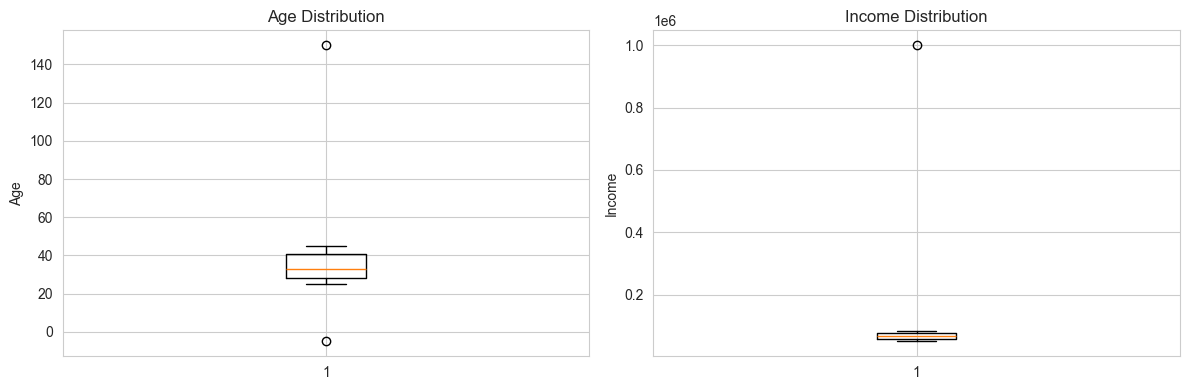


Age statistics:
count     10.0000
mean      41.8000
std       40.4442
min       -5.0000
25%       28.2500
50%       33.0000
75%       41.0000
max      150.0000
Name: age, dtype: float64


In [ ]:
# Visualize potential outliers using box plots
# Box plots show the median, quartiles, and outliers (points beyond whiskers)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].boxplot(clean_data['age'].dropna())
axes[0].set_title('Age Distribution')
axes[0].set_ylabel('Age')

axes[1].boxplot(clean_data['income'].dropna())
axes[1].set_title('Income Distribution')
axes[1].set_ylabel('Income')

plt.tight_layout()
plt.show()

print("\nAge statistics:")
print(clean_data['age'].describe())

In [ ]:
# We'll demonstrate three methods for handling outliers:

# Method 1: Remove outliers using IQR (Interquartile Range)
# IQR = Q3 - Q1. Values beyond Q1-1.5*IQR or Q3+1.5*IQR are considered outliers
def remove_outliers_iqr(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Method 2: Cap outliers at percentiles (Winsorization)
# Instead of removing, we limit extreme values to a specified percentile
def cap_outliers(df, column, lower_percentile=5, upper_percentile=95):
    lower_cap = df[column].quantile(lower_percentile/100)
    upper_cap = df[column].quantile(upper_percentile/100)
    df[column] = df[column].clip(lower=lower_cap, upper=upper_cap)
    return df

# Method 3: Isolation Forest for multivariate outliers
# This ML algorithm detects outliers by isolating observations in feature space
# It works well for detecting outliers across multiple dimensions simultaneously
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_predictions = iso_forest.fit_predict(clean_data[['age', 'income']])

print(f"Outliers detected by Isolation Forest: {(outlier_predictions == -1).sum()}")

# Apply domain knowledge to fix obvious errors
# We know ages can't be negative or > 120, so we mark these as missing
clean_data.loc[clean_data['age'] < 0, 'age'] = np.nan
clean_data.loc[clean_data['age'] > 120, 'age'] = np.nan

print("\nData after handling invalid age values:")
print(clean_data)

Outliers detected by Isolation Forest: 1

Data after handling invalid age values:
    customer_id   age   income              email zip_code
0             1  25.0    50000     john@email.com    12345
1             2  35.0    75000     jane@email.com    23456
3             3   NaN    60000      bob@email.com    34567
4             4   NaN  1000000    alice@email.com    45678
5             5  28.0    55000  charlie@email.com    56789
6             6  42.0    80000    david@email.com    67890
7             7  31.0    62000      eve@email.com    78901
8             8  29.0    58000    frank@email.com    89012
9             9  38.0    70000    grace@email.com    90123
10           10  45.0    85000    henry@email.com    01234


## 2. Feature Value Imputation

**The Missing Data Problem:** Real-world datasets often have missing values due to:
- Data collection failures (sensor errors, survey non-responses)
- Data integration issues (merging datasets with different schemas)
- Privacy concerns (redacted information)
- Human error (forgot to record)

**Why We Can't Ignore It:** Most ML algorithms cannot handle missing values and will either:
- Throw errors
- Automatically drop rows with missing data (losing valuable information)
- Produce biased results

**Imputation Strategies:**
1. **Simple methods**: Mean, median, mode - fast but ignore relationships between features
2. **KNN Imputation**: Uses similar samples to estimate missing values
3. **ML-based**: Predict missing values using other features
4. **Time-series specific**: Forward-fill, backward-fill, interpolation

**Key Consideration:** The best imputation method depends on:
- The amount of missing data (< 5% is often negligible)
- Whether data is Missing Completely At Random (MCAR), Missing At Random (MAR), or Missing Not At Random (MNAR)
- The relationship between features

Let's create a dataset with missing values and explore different imputation techniques.

In [ ]:
# Create a dataset with missing values
# We'll generate a complete dataset, then randomly introduce missing values
np.random.seed(42)
n_samples = 100

data_with_missing = pd.DataFrame({
    'feature_1': np.random.randn(n_samples),
    'feature_2': np.random.randn(n_samples) * 10 + 50,
    'feature_3': np.random.randint(1, 100, n_samples),
    'feature_4': np.random.randn(n_samples) * 5 + 25,
    'category': np.random.choice(['A', 'B', 'C'], n_samples)
})

# Introduce missing values randomly (15% of all values will be missing)
# This simulates Missing Completely At Random (MCAR) scenario
missing_mask = np.random.random(data_with_missing.shape) < 0.15
data_with_missing_copy = data_with_missing.copy()
data_with_missing_copy = data_with_missing_copy.mask(missing_mask)

print("Missing values per column:")
print(data_with_missing_copy.isnull().sum())
print(f"\nTotal missing values: {data_with_missing_copy.isnull().sum().sum()}")
print(f"Percentage missing: {data_with_missing_copy.isnull().sum().sum() / data_with_missing_copy.size * 100:.2f}%")

Missing values per column:
feature_1    15
feature_2    14
feature_3    10
feature_4    17
category     18
dtype: int64

Total missing values: 74
Percentage missing: 14.80%


### 2.1 Simple Imputation Strategies

**Overview:** Simple imputation replaces missing values with a single statistic calculated from the observed data.

**Common Strategies:**
- **Mean imputation**: Best for normally distributed numerical data without extreme outliers
- **Median imputation**: Better for skewed distributions or data with outliers (more robust)
- **Mode imputation**: Used for categorical variables; fills with most frequent category

**Pros:**
- Fast and easy to implement
- Preserves sample size
- Works well when data is MCAR and percentage missing is low

**Cons:**
- Reduces variance in the data
- Ignores relationships between features
- Can introduce bias if data is not MCAR
- Doesn't account for uncertainty

**When to Use:** When missing data < 5%, features are independent, and you need a quick baseline solution.

In [14]:
# Mean imputation for numerical features
mean_imputer = SimpleImputer(strategy='mean')
data_mean_imputed = data_with_missing_copy.copy()
numeric_cols = data_mean_imputed.select_dtypes(include=[np.number]).columns
data_mean_imputed[numeric_cols] = mean_imputer.fit_transform(data_mean_imputed[numeric_cols])

print("Mean Imputation Results:")
print(f"Remaining missing values: {data_mean_imputed.isnull().sum().sum()}")

# Median imputation (more robust to outliers)
median_imputer = SimpleImputer(strategy='median')
data_median_imputed = data_with_missing_copy.copy()
numeric_cols_median = data_median_imputed.select_dtypes(include=[np.number]).columns
data_median_imputed[numeric_cols_median] = median_imputer.fit_transform(data_median_imputed[numeric_cols_median])

print("\nMedian Imputation Results:")
print(f"Remaining missing values: {data_median_imputed.isnull().sum().sum()}")

# Most frequent (mode) imputation for categorical features
mode_imputer = SimpleImputer(strategy='most_frequent')
data_mode_imputed = data_with_missing_copy.copy()
data_mode_imputed['category'] = mode_imputer.fit_transform(data_mode_imputed[['category']]).ravel()

print("\nMode Imputation for Category:")
print(f"Remaining missing values in category: {data_mode_imputed['category'].isnull().sum()}")

Mean Imputation Results:
Remaining missing values: 18

Median Imputation Results:
Remaining missing values: 18

Mode Imputation for Category:
Remaining missing values in category: 0


### 2.2 KNN Imputation

**How It Works:** K-Nearest Neighbors (KNN) imputation finds the k most similar samples (based on other features) and uses their values to estimate the missing value. The final value is typically the mean/median of the k neighbors.

**Advantages:**
- Considers relationships between features
- More accurate than simple imputation when features are correlated
- Can capture local patterns in the data
- Works for both numerical and categorical data

**Disadvantages:**
- Computationally expensive for large datasets (O(n²) complexity)
- Requires feature scaling for meaningful distance calculations
- Performance depends on choosing appropriate k
- Struggles with high-dimensional data (curse of dimensionality)

**Parameters:**
- `n_neighbors`: Number of neighbors to use (default=5). Smaller k = more local patterns, larger k = more stable but averaged estimates

**Best Use Cases:** Medium-sized datasets with correlated features and moderate amounts of missing data.

KNN Imputation Results:
Remaining missing values: 0


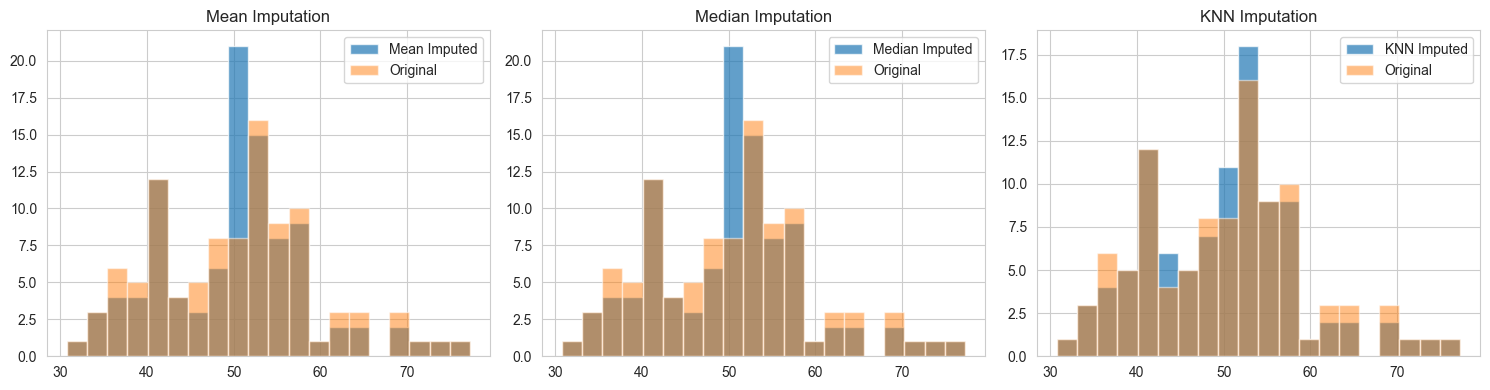

In [ ]:
# KNN Imputation - uses k nearest neighbors to estimate missing values
# For each missing value, it finds the 5 most similar samples (based on Euclidean distance)
# and averages their values
knn_imputer = KNNImputer(n_neighbors=5)
data_knn_imputed = data_with_missing_copy.copy()
data_knn_imputed[numeric_cols] = knn_imputer.fit_transform(data_knn_imputed[numeric_cols])

print("KNN Imputation Results:")
print(f"Remaining missing values: {data_knn_imputed[numeric_cols].isnull().sum().sum()}")

# Compare different imputation methods visually
# The histograms show how each method affects the distribution of feature_2
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(data_mean_imputed['feature_2'], bins=20, alpha=0.7, label='Mean Imputed')
axes[0].hist(data_with_missing['feature_2'], bins=20, alpha=0.5, label='Original')
axes[0].set_title('Mean Imputation')
axes[0].legend()

axes[1].hist(data_median_imputed['feature_2'], bins=20, alpha=0.7, label='Median Imputed')
axes[1].hist(data_with_missing['feature_2'], bins=20, alpha=0.5, label='Original')
axes[1].set_title('Median Imputation')
axes[1].legend()

axes[2].hist(data_knn_imputed['feature_2'], bins=20, alpha=0.7, label='KNN Imputed')
axes[2].hist(data_with_missing['feature_2'], bins=20, alpha=0.5, label='Original')
axes[2].set_title('KNN Imputation')
axes[2].legend()

plt.tight_layout()
plt.show()

### 2.3 Advanced Imputation: Using ML Model Predictions

**Concept:** Treat the feature with missing values as the target variable and use other features to predict it with a machine learning model.

**How It Works:**
1. Separate data into complete cases (no missing value in target) and incomplete cases
2. Train a model (e.g., Random Forest) on complete cases
3. Use trained model to predict missing values in incomplete cases
4. Fill in the predictions

**Advantages:**
- Can capture complex, non-linear relationships between features
- Often more accurate than simpler methods
- Flexible - can use different models (RF, Gradient Boosting, Neural Networks)
- Can handle multiple missing values by iterating through features

**Disadvantages:**
- Computationally intensive
- Risk of overfitting, especially with small datasets
- Adds complexity to preprocessing pipeline
- May propagate errors if other features also have missing values

**When to Use:** When features are highly correlated, you have sufficient data, and accuracy is more important than speed.

In [ ]:
# Use a Random Forest to predict missing values
def ml_imputation(df, target_col, feature_cols):
    """
    Impute missing values using a Random Forest model.
    
    Steps:
    1. Split data into rows where target_col is complete vs. missing
    2. Train Random Forest using complete rows
    3. Predict missing values using the trained model
    4. Fill in predictions
    """
    df_copy = df.copy()
    
    # Split into rows with and without missing values in the target column
    train_data = df_copy[df_copy[target_col].notna()]
    predict_data = df_copy[df_copy[target_col].isna()]
    
    if len(predict_data) == 0:
        return df_copy
    
    # Train Random Forest on complete cases
    # Note: We still need to handle missing values in feature columns using simple imputation
    X_train = train_data[feature_cols].fillna(train_data[feature_cols].mean())
    y_train = train_data[target_col]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_predict = predict_data[feature_cols].fillna(train_data[feature_cols].mean())
    predictions = model.predict(X_predict)
    
    # Fill in the predictions
    df_copy.loc[df_copy[target_col].isna(), target_col] = predictions
    
    return df_copy

# Apply ML imputation to feature_2
data_ml_imputed = ml_imputation(
    data_with_missing_copy, 
    target_col='feature_2', 
    feature_cols=['feature_1', 'feature_3', 'feature_4']
)

print("ML-based Imputation Results:")
print(f"Remaining missing values in feature_2: {data_ml_imputed['feature_2'].isnull().sum()}")

ML-based Imputation Results:
Remaining missing values in feature_2: 0


## 3. Engineered Features

**What is Feature Engineering?** The process of using domain knowledge and creativity to transform raw data into features that better represent the underlying problem, leading to improved model performance.

**Why It Matters:** 
- "Coming up with features is difficult, time-consuming, requires expert knowledge. Applied machine learning is basically feature engineering." - Andrew Ng
- Good features can make simple models outperform complex ones
- Can reduce training time and improve interpretability

**Categories of Engineered Features:**
1. **Polynomial features**: Capture non-linear relationships (x, x², x³)
2. **Interaction features**: Combine features (height × weight = BMI)
3. **Ratio/Difference features**: Relative comparisons (change over time)
4. **Time-based features**: Extract patterns from temporal data
5. **Aggregation features**: Statistical summaries (rolling mean, std)
6. **Binning**: Convert continuous to categorical

**Best Practices:**
- Start with domain knowledge - what makes sense for your problem?
- Create features that align with how the target variable behaves
- Balance complexity vs. interpretability
- Monitor for multicollinearity
- Use cross-validation to avoid overfitting to training data

In [ ]:
# Create a sample dataset for feature engineering
# We'll use a weather-like dataset to demonstrate various feature engineering techniques
np.random.seed(42)
n = 200

engineering_data = pd.DataFrame({
    'temperature': np.random.uniform(15, 35, n),      # Celsius
    'humidity': np.random.uniform(30, 90, n),         # Percentage
    'wind_speed': np.random.uniform(0, 20, n),        # km/h
    'pressure': np.random.uniform(980, 1040, n),      # hPa
    'hour_of_day': np.random.randint(0, 24, n),       # 0-23
    'day_of_week': np.random.randint(0, 7, n)         # 0=Monday, 6=Sunday
})

print("Original Dataset:")
print(engineering_data.head(10))
print(f"\nShape: {engineering_data.shape}")

Original Dataset:
   temperature   humidity  wind_speed     pressure  hour_of_day  day_of_week
0    22.490802  68.521899    2.062477   990.136104            7            1
1    34.014286  35.048398   18.051058   996.715420            9            1
2    29.639879  39.697723   10.105047   990.620629           16            4
3    26.973170  83.913251   16.529149   985.322152            8            4
4    18.120373  66.385744    6.400992   987.238152           21            1
5    18.119890  30.551823   17.910465  1007.646726           18            6
6    16.161672  36.088293    7.784034   992.380023           13            4
7    32.323523  69.810106    0.216753  1001.856192            7            2
8    27.022300  30.303695   18.107640  1010.205036            8            5
9    29.161452  39.648483    1.825734  1021.423690           21            1

Shape: (200, 6)


### 3.1 Polynomial Features

**What Are They?** Polynomial features create new features by raising existing features to powers (x², x³) and creating products of features.

**Mathematical Form:** For features [x₁, x₂], degree=2 creates: [x₁, x₂, x₁², x₁x₂, x₂²]

**When to Use:**
- When relationships between features and target are non-linear
- When you suspect quadratic or higher-order effects
- Common in physical/scientific problems (e.g., kinetic energy ∝ velocity²)

**Caution:**
- Number of features explodes with degree: n features → n(n+1)/2 for degree 2
- Can lead to overfitting if not regularized
- Increases computational cost

**Example:** Temperature might affect energy consumption quadratically (heating and cooling needs)

In [ ]:
# Create polynomial features using scikit-learn's PolynomialFeatures
# degree=2 will create: original features, squared features, and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
numerical_features = ['temperature', 'humidity', 'wind_speed']
poly_features = poly.fit_transform(engineering_data[numerical_features])

# Get feature names to see what was created
poly_feature_names = poly.get_feature_names_out(numerical_features)

print(f"Original features: {len(numerical_features)}")
print(f"Polynomial features (degree 2): {len(poly_feature_names)}")
print(f"\nNew feature names: {poly_feature_names}")
print("\nThis creates: original 3 features + 3 squared terms + 3 interaction terms = 9 total")

Original features: 3
Polynomial features (degree 2): 9

New feature names: ['temperature' 'humidity' 'wind_speed' 'temperature^2'
 'temperature humidity' 'temperature wind_speed' 'humidity^2'
 'humidity wind_speed' 'wind_speed^2']


### 3.2 Interaction Features

**What Are They?** Features created by multiplying two or more features together to capture their combined effect.

**Intuition:** Sometimes two features individually don't predict the target well, but their combination does.

**Real-World Examples:**
- **BMI** = weight × height⁻² (interaction of weight and height)
- **Wind chill** = f(temperature, wind_speed) - feels colder when windy
- **Heat index** = f(temperature, humidity) - feels hotter when humid
- **Total cost** = quantity × price_per_unit

**When to Use:**
- When the effect of one feature depends on another (moderation effects)
- When domain knowledge suggests combined effects matter
- In economics, biology, chemistry where multiplicative effects are common

**In This Example:** We'll create weather interaction features that capture combined atmospheric effects.

In [ ]:
# Create interaction features manually
# These capture how features work together to influence outcomes

# Temperature × Humidity: Captures "feels like" temperature (heat index effect)
engineering_data['temp_humidity_interaction'] = engineering_data['temperature'] * engineering_data['humidity']

# Temperature × Wind: Captures wind chill effect
engineering_data['temp_wind_interaction'] = engineering_data['temperature'] * engineering_data['wind_speed']

# Humidity × Wind: Captures evaporation/drying effect
engineering_data['humidity_wind_interaction'] = engineering_data['humidity'] * engineering_data['wind_speed']

print("Interaction Features:")
print(engineering_data[['temperature', 'humidity', 'temp_humidity_interaction']].head())

Interaction Features:
   temperature   humidity  temp_humidity_interaction
0    22.490802  68.521899                1541.112484
1    34.014286  35.048398                1192.146234
2    29.639879  39.697723                1176.635695
3    26.973170  83.913251                2263.406366
4    18.120373  66.385744                1202.934423


### 3.3 Ratio and Difference Features

**Ratio Features:** Dividing one feature by another creates relative measures that can be more informative than absolute values.

**Why Ratios Matter:**
- Normalize for scale differences (e.g., revenue per employee, not just total revenue)
- Create dimensionless quantities useful for comparison
- Often more stable than raw values

**Difference Features:** Subtracting values creates measures of change, deviation, or distance.

**Common Use Cases:**
- **Finance**: Debt-to-income ratio, profit margin (profit/revenue)
- **Health**: BMI (weight/height²), waist-to-hip ratio
- **Engineering**: Efficiency ratios, speed ratios
- **Anomaly Detection**: Deviation from mean/median

**Caution:** Always add small epsilon (e.g., 1e-5) to denominators to avoid division by zero.

In [ ]:
# Create ratio features - these express relationships between variables
# Ratio features are often more informative than absolute values

# Temperature to Humidity ratio (add epsilon to avoid division by zero)
engineering_data['temp_humidity_ratio'] = engineering_data['temperature'] / (engineering_data['humidity'] + 1e-5)

# Wind speed normalized by pressure (atmospheric density effect)
engineering_data['wind_pressure_ratio'] = engineering_data['wind_speed'] / engineering_data['pressure']

# Create difference features - measuring deviation from central tendency
# This captures how unusual the temperature is
engineering_data['temp_deviation'] = engineering_data['temperature'] - engineering_data['temperature'].mean()

print("Ratio and Difference Features:")
print(engineering_data[['temperature', 'humidity', 'temp_humidity_ratio', 'temp_deviation']].head())

Ratio and Difference Features:
   temperature   humidity  temp_humidity_ratio  temp_deviation
0    22.490802  68.521899             0.328228       -2.189322
1    34.014286  35.048398             0.970494        9.334161
2    29.639879  39.697723             0.746639        4.959754
3    26.973170  83.913251             0.321441        2.293045
4    18.120373  66.385744             0.272956       -6.559752


### 3.4 Time-Based Features

**The Cyclical Nature of Time:** Hours, days, months are cyclical - midnight (0) is close to 11 PM (23), but numerically far apart. Standard encoding treats time as linear, which is incorrect.

**Cyclical Encoding with Sin/Cos:**
- Convert cyclical variables to sin and cos components
- Preserves the circular relationship: hour 0 is close to hour 23
- **Formula**: sin(2π × value / period) and cos(2π × value / period)

**Why Two Components?** 
- Sin alone creates ambiguity (sin(30°) = sin(150°))
- Sin + Cos together uniquely identify position on the circle

**Categorical Time Features:**
- Binary flags: is_weekend, is_holiday, is_rush_hour
- Multi-category: season, quarter, day_part

**Use Cases:** Sales forecasting, demand prediction, energy consumption, traffic prediction, any time-dependent problem.

In [ ]:
# Create cyclical features for time using sine and cosine transformations
# This preserves the circular nature of time (hour 23 is close to hour 0)

# Hour of day (24-hour cycle): 2π × hour / 24
engineering_data['hour_sin'] = np.sin(2 * np.pi * engineering_data['hour_of_day'] / 24)
engineering_data['hour_cos'] = np.cos(2 * np.pi * engineering_data['hour_of_day'] / 24)

# Day of week (7-day cycle): 2π × day / 7
engineering_data['day_sin'] = np.sin(2 * np.pi * engineering_data['day_of_week'] / 7)
engineering_data['day_cos'] = np.cos(2 * np.pi * engineering_data['day_of_week'] / 7)

# Create time-based categorical features using domain knowledge
# Rush hour: 7-9 AM and 5-7 PM (typical commute times)
engineering_data['is_rush_hour'] = engineering_data['hour_of_day'].apply(
    lambda x: 1 if (7 <= x <= 9) or (17 <= x <= 19) else 0
)

# Weekend: Saturday (5) and Sunday (6)
engineering_data['is_weekend'] = engineering_data['day_of_week'].apply(
    lambda x: 1 if x >= 5 else 0
)

print("Time-Based Features:")
print(engineering_data[['hour_of_day', 'hour_sin', 'hour_cos', 'is_rush_hour']].head(10))

Time-Based Features:
   hour_of_day  hour_sin      hour_cos  is_rush_hour
0            7  0.965926 -2.588190e-01             1
1            9  0.707107 -7.071068e-01             1
2           16 -0.866025 -5.000000e-01             0
3            8  0.866025 -5.000000e-01             1
4           21 -0.707107  7.071068e-01             0
5           18 -1.000000 -1.836970e-16             1
6           13 -0.258819 -9.659258e-01             0
7            7  0.965926 -2.588190e-01             1
8            8  0.866025 -5.000000e-01             1
9           21 -0.707107  7.071068e-01             0


### 3.5 Aggregation Features

**What Are They?** Statistical summaries calculated over a window of observations - particularly useful for time series and sequential data.

**Common Aggregations:**
- **Rolling statistics**: mean, median, std, min, max over n previous observations
- **Lag features**: Values from t-1, t-2, ... t-n
- **Cumulative statistics**: cumulative sum, cumulative max
- **Exponentially weighted**: Gives more weight to recent observations

**Why They Help:**
- Capture trends and patterns over time
- Smooth out noise in the data
- Represent recent history/context
- Useful for detecting anomalies (current value vs. historical pattern)

**Parameters:**
- **window_size**: How many observations to include (larger = smoother, smaller = more responsive)
- **min_periods**: Minimum observations required (important for beginning of series)

**Applications:** Stock prices, sensor data, sales forecasting, web traffic, IoT data.

In [ ]:
# Create aggregation features using rolling statistics
# First, sort by time to ensure chronological order
engineering_data_sorted = engineering_data.sort_values('hour_of_day').reset_index(drop=True)

# Rolling statistics: Calculate mean and std over a sliding window
window_size = 5  # Look at the previous 5 observations

# Rolling mean: Smooths out short-term fluctuations, highlights trends
engineering_data_sorted['temp_rolling_mean'] = engineering_data_sorted['temperature'].rolling(
    window=window_size, min_periods=1  # min_periods=1 allows calculation even with fewer points
).mean()

# Rolling std: Measures local variability/volatility
engineering_data_sorted['temp_rolling_std'] = engineering_data_sorted['temperature'].rolling(
    window=window_size, min_periods=1
).std()

print("Aggregation Features:")
print(engineering_data_sorted[['temperature', 'temp_rolling_mean', 'temp_rolling_std']].head(10))
print("\nNote: First few rows have increasing window sizes until window_size is reached")

Aggregation Features:
   temperature  temp_rolling_mean  temp_rolling_std
0    26.958000          26.958000               NaN
1    17.201038          22.079519          6.899213
2    33.593953          25.917664          8.245825
3    23.207658          25.240162          6.867687
4    15.110442          23.214218          7.476369
5    21.219646          22.066548          7.193070
6    27.237058          24.073752          6.889806
7    25.454657          22.445892          4.687769
8    27.191287          23.242618          5.163946
9    19.841105          24.188751          3.450635


### 3.6 Binning and Discretization

**What is Binning?** Converting continuous numerical features into categorical bins or groups.

**Why Bin Data?**
- **Non-linear relationships**: Capture threshold effects (e.g., credit score > 700 = approved)
- **Robustness**: Less sensitive to outliers and noise
- **Interpretability**: Easier to understand and explain ("high income" vs. "73,542")
- **Model requirements**: Some models work better with categorical data
- **Reduce overfitting**: Smooths the relationship with target

**Types of Binning:**
- **Equal-width**: Divide range into equal-sized bins
- **Equal-frequency (quantile)**: Each bin has same number of samples
- **Custom bins**: Based on domain knowledge (e.g., age groups, tax brackets)

**Trade-offs:**
- ✅ Reduces impact of outliers and measurement errors
- ✅ Can capture non-linear patterns
- ❌ Loses information (precision)
- ❌ Introduces artificial boundaries
- ❌ Requires deciding on number/size of bins

**When to Use:** When you suspect threshold effects, have domain knowledge about meaningful categories, or need interpretability.

In [ ]:
# Create binned features using pd.cut (equal-width binning with custom boundaries)
# We define bins based on domain knowledge about temperature and humidity

# Temperature categories based on comfort/weather classifications
engineering_data['temp_category'] = pd.cut(
    engineering_data['temperature'],
    bins=[0, 20, 25, 30, 100],  # Custom boundaries based on weather understanding
    labels=['Cold', 'Mild', 'Warm', 'Hot']
)

# Humidity categories based on comfort levels
engineering_data['humidity_category'] = pd.cut(
    engineering_data['humidity'],
    bins=[0, 40, 60, 80, 100],  # 0-40: dry, 40-60: comfortable, 60-80: humid, 80+: very humid
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("Binned Features:")
print(engineering_data[['temperature', 'temp_category', 'humidity', 'humidity_category']].head(10))
print(f"\nFinal dataset shape: {engineering_data.shape}")
print(f"We've added {engineering_data.shape[1] - 6} new engineered features to the original 6!")

Binned Features:
   temperature temp_category   humidity humidity_category
0    22.490802          Mild  68.521899              High
1    34.014286           Hot  35.048398               Low
2    29.639879          Warm  39.697723               Low
3    26.973170          Warm  83.913251         Very High
4    18.120373          Cold  66.385744              High
5    18.119890          Cold  30.551823               Low
6    16.161672          Cold  36.088293               Low
7    32.323523           Hot  69.810106              High
8    27.022300          Warm  30.303695               Low
9    29.161452          Warm  39.648483               Low

Final dataset shape: (200, 20)


## 4. Denoising With ML Models

**What is Data Denoising?** The process of removing or reducing random variations (noise) from data to reveal the underlying signal or pattern.

**Sources of Noise:**
- Measurement errors (sensor inaccuracy, human mistakes)
- Environmental interference
- Data transmission errors
- Sampling variability
- Inherent randomness in the process

**Why Denoise?**
- Improves model performance by focusing on signal, not noise
- Reduces overfitting to random fluctuations
- Reveals true patterns and relationships
- Improves data visualization and interpretation

**ML Denoising Techniques:**
1. **PCA (Principal Component Analysis)**: Projects data to lower dimensions, filtering out noisy components
2. **Autoencoders**: Neural networks that learn compressed representations
3. **Ensemble Methods**: Average predictions from multiple models to cancel out noise
4. **Anomaly Detection**: Identify and remove anomalous noisy samples

**Key Insight:** Noise is typically high-frequency and low-variance. Signal is low-frequency and high-variance. ML methods exploit this to separate them.

In [ ]:
# Create a noisy dataset to demonstrate denoising techniques
np.random.seed(42)
n_samples = 500
n_features = 10

# Generate clean signal with known relationship
# True relationship: y = 2*x₀ + 1.5*x₁ + 0.5*x₂
X_clean = np.random.randn(n_samples, n_features)
true_signal = X_clean[:, 0] * 2 + X_clean[:, 1] * 1.5 + X_clean[:, 2] * 0.5

# Add Gaussian noise to both features and target
noise_level = 0.5
X_noisy = X_clean + np.random.randn(n_samples, n_features) * noise_level
y_noisy = true_signal + np.random.randn(n_samples) * noise_level

print(f"Dataset shape: {X_noisy.shape}")
print(f"Signal-to-Noise Ratio: {np.var(true_signal) / np.var(y_noisy - true_signal):.2f}")
print("\nHigher SNR = cleaner data. SNR < 1 means noise dominates.")

Dataset shape: (500, 10)
Signal-to-Noise Ratio: 29.76


### 4.1 PCA for Denoising

**How PCA Denoises:**
1. Identifies principal components (directions of maximum variance)
2. Signal typically lies in first few components (high variance)
3. Noise is spread across all components (especially later ones with low variance)
4. Keep only top k components, discard the rest → removes noise

**Process:**
1. Standardize data (PCA is sensitive to scale)
2. Apply PCA, keeping components that explain 95% variance
3. Transform data to PCA space
4. Inverse transform back to original space (without noisy components)

**Benefits:**
- Unsupervised - doesn't need labels
- Reduces dimensionality and noise simultaneously
- Fast and deterministic

**Limitations:**
- Assumes linear relationships
- May lose signal if noise and signal overlap in principal components
- Requires choosing number of components (variance threshold)

**Rule of Thumb:** If top k components explain > 90-95% variance, remaining components are likely noise.

Original features: 10
PCA components: 10
Explained variance ratio: [0.11652333 0.1129449  0.11137396 0.10484267 0.10319631 0.09713114
 0.09219871 0.08990833 0.0872276  0.08465304]
Total variance explained: 1.0000


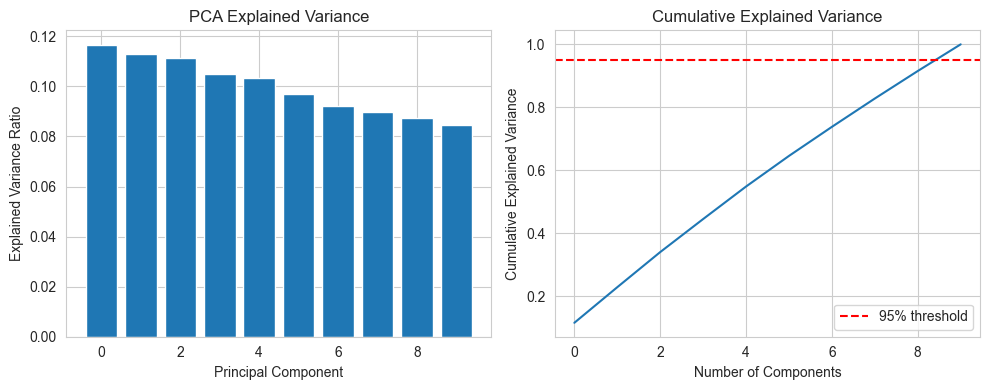

In [ ]:
# Apply PCA to reduce noise by filtering out low-variance components
# Step 1: Scale the data (PCA is sensitive to feature scales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_noisy)

# Step 2: Apply PCA keeping components that explain 95% of variance
# The remaining 5% is assumed to be mostly noise
pca = PCA(n_components=0.95)  # Keep components explaining 95% variance
X_pca = pca.fit_transform(X_scaled)  # Transform to PCA space
X_denoised_pca = pca.inverse_transform(X_pca)  # Transform back to original space
X_denoised_pca = scaler.inverse_transform(X_denoised_pca)  # Unscale

print(f"Original features: {n_features}")
print(f"PCA components kept: {pca.n_components_}")
print(f"Components discarded (noise): {n_features - pca.n_components_}")
print(f"\nExplained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Visualize explained variance to see signal vs. noise components
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance (Signal Components)')

plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### 4.2 Ensemble Methods for Robust Predictions

**How Ensembles Denoise:**
- Train multiple models on the same data
- Each model learns different patterns and makes different errors
- Average their predictions → random errors cancel out, signal reinforces

**Random Forest as Denoiser:**
- Builds many decision trees on random subsets of data and features
- Each tree overfits differently to noise
- Averaging predictions across trees smooths out noise
- **Bias-Variance Trade-off**: Higher individual tree variance, but low ensemble variance

**Why It Works:**
- **Wisdom of crowds**: Collective prediction more accurate than individual
- Noise is random → averages to zero
- Signal is consistent → reinforces across models

**Advantages:**
- Works with non-linear relationships
- No need to specify denoising parameters
- Automatically robust to outliers and noise

**This Example:** We'll compare predictions on noisy data vs. the true underlying signal to quantify denoising effect.

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_noisy, y_noisy, test_size=0.2, random_state=42
)

# Train Random Forest (inherently denoises through ensemble averaging)
# 100 trees each make predictions, then we average them
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Calculate true signal for test set (we know the true relationship)
X_test_indices = X_test[:, :3]  # We know the first 3 features are important
y_true_signal = X_test_indices[:, 0] * 2 + X_test_indices[:, 1] * 1.5 + X_test_indices[:, 2] * 0.5

# Compare performance: How close are we to the TRUE signal?
mse_noisy = mean_squared_error(y_true_signal, y_test)  # MSE of noisy data
mse_rf = mean_squared_error(y_true_signal, y_pred_rf)  # MSE of RF predictions

print(f"MSE (noisy data): {mse_noisy:.4f}")
print(f"MSE (Random Forest predictions): {mse_rf:.4f}")
print(f"Improvement: {(1 - mse_rf/mse_noisy) * 100:.2f}%")
print("\nRandom Forest successfully filters noise by ensemble averaging!")

MSE (noisy data): 1.8816
MSE (Random Forest predictions): 1.1317
Improvement: 39.86%


### 4.3 Anomaly Detection for Noise Removal

**Concept:** Instead of denoising individual values, identify and remove entire noisy samples (outliers/anomalies) before training.

**Isolation Forest Algorithm:**
- Builds random decision trees that isolate observations
- Anomalies are easier to isolate (fewer splits needed)
- Normal points are harder to isolate (more splits needed)
- Returns anomaly score for each sample

**How It Helps:**
- Removes samples with extreme noise or errors
- Prevents model from learning patterns that don't generalize
- Particularly effective when noise manifests as outlier samples

**Parameter:**
- `contamination`: Expected proportion of outliers (default 0.1 = 10%)

**Strategy:**
1. Use Isolation Forest to detect anomalies in training set
2. Remove detected anomalies
3. Train model on clean training set
4. Evaluate on test set

**Caution:** Don't remove anomalies from test set! You want to see how model performs on all real-world data, including potential outliers.

In [ ]:
# Use Isolation Forest to detect and remove noisy samples from training data
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # Expect 10% outliers
anomaly_labels = iso_forest.fit_predict(X_train)  # 1 = normal, -1 = anomaly

# Remove anomalies from training set only (keep all test data)
X_train_clean = X_train[anomaly_labels == 1]
y_train_clean = y_train[anomaly_labels == 1]

print(f"Original training samples: {len(X_train)}")
print(f"Anomalies detected: {(anomaly_labels == -1).sum()}")
print(f"Clean training samples: {len(X_train_clean)}")
print(f"Percentage removed: {(anomaly_labels == -1).sum() / len(X_train) * 100:.1f}%")

# Train model on cleaned data
rf_clean = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = rf_clean.predict(X_test)

# Compare to true signal
mse_clean = mean_squared_error(y_true_signal, y_pred_clean)
print(f"\nMSE (after anomaly removal): {mse_clean:.4f}")
print(f"Additional improvement over RF alone: {(1 - mse_clean/mse_rf) * 100:.2f}%")
print(f"Total improvement over noisy data: {(1 - mse_clean/mse_noisy) * 100:.2f}%")

Original training samples: 400
Anomalies detected: 40
Clean training samples: 360

MSE (after anomaly removal): 0.9573
Additional improvement: 15.41%


### 4.4 Comparison Visualization

**What We're Visualizing:** Three different approaches to handling noisy data, showing how predictions compare to the true underlying signal.

**Plots:**
1. **Left**: Noisy data vs. true signal - shows the raw problem
2. **Middle**: Random Forest predictions - demonstrates ensemble denoising
3. **Right**: RF trained on anomaly-cleaned data - combines both techniques

**Key Observations:**
- Noisy data has high variance around true signal (scattered points)
- Random Forest smooths predictions, following general trend
- Anomaly removal + RF produces tightest fit to true signal

**Take-Away:** Combining multiple denoising techniques (ensemble methods + anomaly removal) often yields best results.

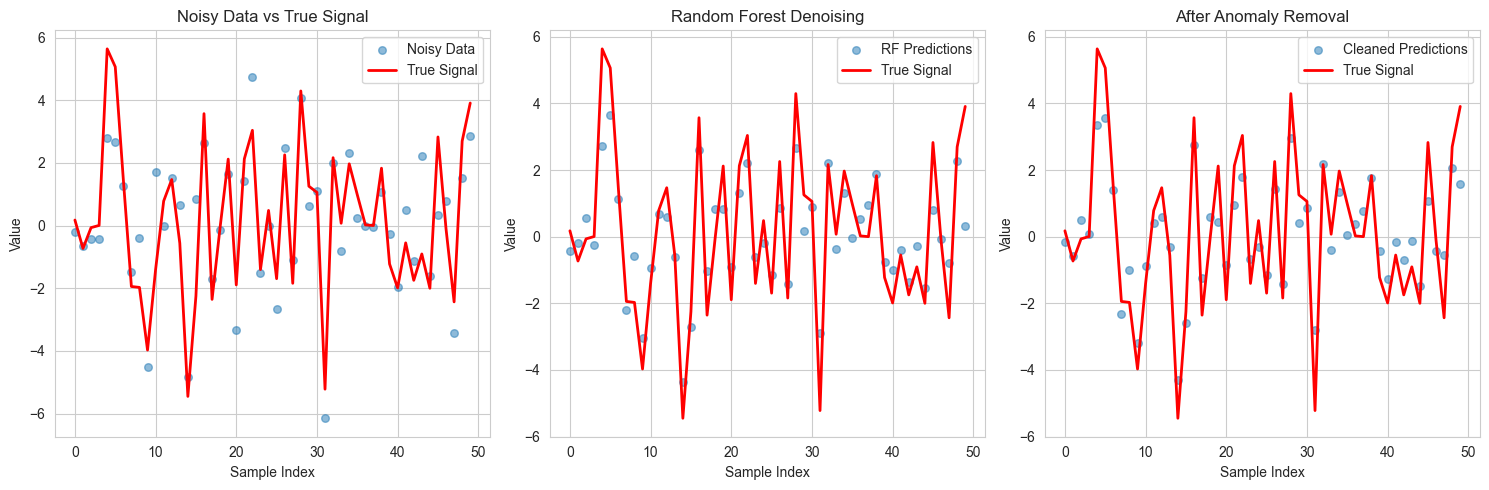

In [24]:
# Visualize denoising results
plt.figure(figsize=(15, 5))

# Plot 1: Noisy vs True Signal
plt.subplot(1, 3, 1)
sample_indices = range(50)
plt.scatter(sample_indices, y_test[sample_indices], alpha=0.5, label='Noisy Data', s=30)
plt.plot(sample_indices, y_true_signal[sample_indices], 'r-', linewidth=2, label='True Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Noisy Data vs True Signal')
plt.legend()

# Plot 2: Random Forest Predictions
plt.subplot(1, 3, 2)
plt.scatter(sample_indices, y_pred_rf[sample_indices], alpha=0.5, label='RF Predictions', s=30)
plt.plot(sample_indices, y_true_signal[sample_indices], 'r-', linewidth=2, label='True Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Random Forest Denoising')
plt.legend()

# Plot 3: Cleaned Model Predictions
plt.subplot(1, 3, 3)
plt.scatter(sample_indices, y_pred_clean[sample_indices], alpha=0.5, label='Cleaned Predictions', s=30)
plt.plot(sample_indices, y_true_signal[sample_indices], 'r-', linewidth=2, label='True Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('After Anomaly Removal')
plt.legend()

plt.tight_layout()
plt.show()

## Summary

In this notebook, we covered advanced feature engineering techniques:

1. **Dealing with Dirty Data**: We learned how to handle duplicates, standardize text data, and detect/handle outliers using IQR, capping, and Isolation Forest.

2. **Feature Value Imputation**: We explored various imputation strategies including simple imputation (mean, median, mode), KNN imputation, and ML-based imputation using Random Forest.

3. **Engineered Features**: We created new features through:
   - Polynomial features
   - Interaction features
   - Ratio and difference features
   - Time-based features (cyclical encoding)
   - Aggregation features (rolling statistics)
   - Binning and discretization

4. **Denoising With ML Models**: We demonstrated denoising techniques using:
   - PCA for dimensionality reduction and noise filtering
   - Ensemble methods (Random Forest) for robust predictions
   - Anomaly detection (Isolation Forest) for noise removal

These techniques are essential for improving model performance and should be applied based on your specific dataset and problem domain.